## The case for Area as the fundamental unit

This notebook contains a prototype for exploring the case for area as the fundamental unit of measure instead of the volume, following the description here: https://docs.google.com/document/d/1GVUEv8l9T3zogKvIThCUAWN_tbZdpu2-MbE3PyOQepw/edit#heading=h.9qcog0t53hjq

The idea behind would be to use Purchase Area as equivalent to Volume (i.e. _what is the area required to produce the purchased volume?_)

For that we need the yield in each location to distribute that area. Ths can be done following this formula if we have pixel-resolution yield:

	f’ = f.V / a.y Σf
    
- f': fractional area used to produce the commodity such that the sum of all pixels within some area of interest equals the Purchase Area (unitless)

- f: the (estimated) fractional area used to to produce the commodity, where Σf is equal to the total possible commodity production area (unitless)

- a: pixel area (ha)

- y: the yeild of the commodity in a given pixel (t/ha)

- V: the known purchased Volume (t)


## Table of Contents
- ### [1. Import libraries](#libraries)
- ### [2. Import user data](#user_data)
- ### [3. Generate purchase area probability map](#probability_map)
    - #### [3.1. Generate raster with volume info](#volume)
    - #### [3.2. Obtain raster with total fraction area](#area_fraction)
        - #### [3.2.1. Calculate raster with pixel area](#pixel_area)
        - #### [3.2.2. Calculate raster for total area fraction](#total_area)
        - #### [3.2.2. Calculate zonal statistics for user data and raster](#zonal_stats)
    - #### [3.3. Calculate probability map](#calculation)
- ### [4. Final notes](#finalNotes)

<a id='libraries'></a>
### 1. Import libraries:

In [11]:
## import libraries
import time

import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.plot
from rasterstats import zonal_stats

<a id='user_data'></a>
### 2. Import user data



In [12]:
## import user data
## projection of user data is epsg:4326
input_data = gpd.read_file("../../datasets/processed/user_data/located_lg_data_polygon_v2.shp")
input_data.head()

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,Rubber,None,2400,China,None,None,None,Unknown,Low,"MULTIPOLYGON (((73.49973 39.38174, 73.50468 39..."
1,Rubber,None,1300,Malaysia,None,None,None,Unknown,Low,"MULTIPOLYGON (((98.93721 5.68384, 98.93771 5.6..."
2,Rubber,None,1000,United States,None,None,None,Unknown,Low,"MULTIPOLYGON (((-180.00000 51.79409, -180.0000..."
3,Rubber,None,730,Japan,None,None,None,Unknown,Low,"MULTIPOLYGON (((122.71418 24.44983, 122.71457 ..."
4,Rubber,None,490,India,None,None,None,Unknown,Low,"MULTIPOLYGON (((68.11138 23.60145, 68.13528 23..."


In [13]:
## check the commodities materials - we will need to generate a distribution map for each of the commodities.

print("The uniques commodities from the user data are:", set(input_data["Material"]))

The uniques commodities from the user data are: {'Leather', 'Cotton', 'Rubber'}


We are going to use a test location from the user data to generate the purchase area probability map. Therefore we're going to select a test location from the gdf above:

In [14]:
test_location = input_data.loc[
    (input_data["Material"] == "Cotton")
    & (input_data["Country"] == "India")
    & ((input_data["Volume"] == 745))
]
test_location

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
18,Cotton,None,745,India,None,None,None,Unknown,Low,"MULTIPOLYGON (((68.11138 23.60145, 68.13528 23..."


In [15]:
test_location = test_location.set_crs("EPSG:4326")
print(f"projection of user data is: {test_location.crs}")

projection of user data is: EPSG:4326


In [17]:
# reproject to epsg3857
test_location = test_location.to_crs("EPSG:3857")

In [18]:
test_location.to_file(
    "../../datasets/raw/probability_map/test_location_epsg3857.shp", driver="ESRI Shapefile"
)

<a id='probability_map'></a>
### 3. Generate purchase area probability map

For the purchase area probability map we will need:

- The purchased volume which is provided by the user as we can see above
- The area fraction for the commodity of interest (in this case cotton) - obtained from EarthStat
- The yield of the commodity of interest (in this case cotton) - obtained from EarthStat

The formula (per pixel) is:

    f'= Ap*Af/At
    
  where:
      Ap = Volume/pixel_yield
      Af = Area fraction for that user
      At = Total area fraction in area of interest
      
 NOTE: The probability map test is going to be produced just for a commodity and for a particular location. However this would need to be updated for the differenet commodities and for all the user data.
 
In that case we can produce an intermediate dataset whit a world coverage for each commodity following the formula:

    f'' = Af (commodity) / Yield(commodity)
    
 This could be multiplied by the user volume and the total area within a particular location later on.

In [19]:
yield_cotton = "../../datasets/raw/crop_data/cotton_YieldPerHectare.tif"
harvest_portion_cotton = "../../datasets/raw/crop_data/cotton_HarvestedAreaFraction.tif"

<a id='volume'></a>
#### 3.1. Generate raster with volume info

In [20]:
!gdalinfo -stats -hist '../../datasets/raw/crop_data/cotton_HarvestedAreaFraction.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/crop_data/cotton_HarvestedAreaFraction.tif
       ../../datasets/raw/crop_data/cotton_HarvestedAreaFraction.tif.aux.xml
Size is 4320, 2160
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000000000000000,89.999999999989768)
Pixel Size = (0.083333333333329,-0.083333333333329)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_SOFTWARE=MATLAB 8.0, Mapping Toolbox 3.6
Image Structure Metadata:
  COMPRESSION=PACKBITS
  INTERLEAVE=BAN

In [21]:
!gdalinfo -stats -hist '../../datasets/raw/crop_data/cotton_YieldPerHectare.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/crop_data/cotton_YieldPerHectare.tif
       ../../datasets/raw/crop_data/cotton_YieldPerHectare.tif.aux.xml
Size is 4320, 2160
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000000000000000,89.999999999989768)
Pixel Size = (0.083333333333329,-0.083333333333329)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_SOFTWARE=MATLAB 8.0, Mapping Toolbox 3.6
Image Structure Metadata:
  COMPRESSION=PACKBITS
  INTERLEAVE=BAND
Corner Coo

In [23]:
# reproject harvest area fraction
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -tr 12051.131160772875 12051.131160772875 -r near -of GTiff ../../datasets/raw/crop_data/cotton_HarvestedAreaFraction.tif ../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857.tif

Creating output file that is 3325P x 36024L.
Processing ../../datasets/raw/crop_data/cotton_HarvestedAreaFraction.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [25]:
# reproject yield
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -tr 12051.131160772875 12051.131160772875 -r near -of GTiff ../../datasets/raw/crop_data/cotton_YieldPerHectare.tif ../../datasets/raw/crop_data/cotton_YieldPerHectare_epsg3857.tif

Creating output file that is 3325P x 36024L.
Processing ../../datasets/raw/crop_data/cotton_YieldPerHectare.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [24]:
# check infor of the reprojected raster
!gdalinfo -stats -hist '../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857.tif
Size is 3325, 36024
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]],
        PAR

In [26]:
!gdalinfo -stats -hist '../../datasets/raw/crop_data/cotton_YieldPerHectare_epsg3857.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/crop_data/cotton_YieldPerHectare_epsg3857.tif
Size is 3325, 36024
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]],
        PARAMETER

In [34]:
## generate a raster with same resolution as the yield and harvest portion
## with the user volume

## this should be run by each of the user data - producing a final raster with the total volume for each location
!gdal_rasterize -l test_location_epsg3857 -a Volume -tr 12051.131160772875 12051.131160772875 -a_nodata 0.0 -te -20037508.3428 -242486969.8524 20032502.7668 191642979.0833 -ot Float32 -of GTiff '../../datasets/raw/probability_map/test_location_epsg3857.shp' '../../datasets/raw/probability_map/test_location_raster_volume_epsg3857.tif'

0...10...20...30...40...50...60...70...80...90...100 - done.


In [35]:
## add projection - same as the other ones for the calculations
!gdal_edit.py -a_srs EPSG:3857 '../../datasets/raw/probability_map/test_location_raster_volume_epsg3857.tif'

<a id='area_fraction'></a>
### 3.2. Obtain raster with total fraction area

In [36]:
## calculate pixel area based on pixel size
pixel_area = 12051.131160772874864 * 12051.131160772874864
print(f"The pixel area is {pixel_area} m2")

The pixel area is 145229762.254151 m2


<a id='pixel_area'></a>
#### 3.2.1. Calculate raster with pixel area

In [30]:
# generate raster with pixel area raster
# reclasifies the raster into 0 and pixel area being the pixel area just on thise locations with harvest area fraction
!gdal_calc.py -A '../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857.tif' --outfile='../../datasets/raw/probability_map/pixel_area_cotton_raster_epsg3857.tif' --calc="(A > 0) * 145229762.254151"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 

11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 

20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 

29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 

38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 

47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 

56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 

65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 

74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 

83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 

92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 

<a id='total_area'></a>
#### 3.2.2. Calculate raster for total area fraction

In [31]:
## calculate the raster equal to pixel_are * area fraction to get the total area within a loctaion with summary statistics
!gdal_calc.py -A '../../datasets/raw/probability_map/pixel_area_cotton_raster_epsg3857.tif' -B '../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857.tif'  --outfile='../../datasets/raw/probability_map/area_total_cotton_raster_epsg3857.tif' --calc="(A * B)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 

11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 

20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 

29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 

38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 

47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 

56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 

65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 

74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 

83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 

92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 

<a id='zonal_stats'></a>
#### 3.2.2. Calculate zonal statistics for user data and raster

NOTE: We will need to extend this to all user data

In [32]:
# zonal stats in india to get the sum of all fraction harvest area
total_harves_area_cotton = (
    "../../datasets/raw/probability_map/area_total_cotton_raster_epsg3857.tif"
)
start_time = time.time()
zs_india_test = zonal_stats(test_location, total_harves_area_cotton, stats="sum")
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.19099926948547363 seconds ---


In [33]:
print(" The total cotton harvest area in india is :", {zs_india_test[0]["sum"]}, "m2")

 The total cotton harvest area in india is : {83570565120.0} m2


In [34]:
## ad field to gdf
test_location["Total_af"] = zs_india_test[0]["sum"]
test_location

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry,Total_af
18,Cotton,None,745,India,None,None,None,Unknown,Low,"MULTIPOLYGON (((7582123.994 2704917.800, 75847...",8.357057e+10


In [35]:
test_location.to_file(
    "../../datasets/raw/probability_map/test_location_epsg3857.shp", driver="ESRI Shapefile"
)

In [59]:
## generate a raster with same extent as the other ones with this total area fraction value
!gdal_rasterize -l test_location_epsg3857 -a Total_af -tr 12051.131160772875 12051.131160772875 -a_nodata 0.0 -te -20037508.3428 -242486969.8524 20032502.7668 191642979.0833 -ot Float32 -of GTiff '../../datasets/raw/probability_map/test_location_epsg3857.shp' '../../datasets/raw/probability_map/test_location_raster_total_af.tif'

0...10...20...30...40...50...60...70...80...90...100 - done.


In [60]:
## add projection - same as the other ones for the calculations
!gdal_edit.py -a_srs EPSG:3857 '../../datasets/raw/probability_map/test_location_raster_total_af.tif'

<a id='calculation'></a>
### 3.3. Calculate probability map

The formula would be: 

    f' = (V * Af) / (AT * Yield)
    
to do this we will need the folloing datasets:

- volume raster derived from user data: '../../datasets/raw/probability_map/test_location_raster_volume_epsg3857.tif'
- area fraction for a particular commodity: '../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857.tif'
- the total area fraction for the user location: '../../datasets/raw/probability_map/area_total_cotton_raster_epsg3857.tif'
- yield information for a particular commodity: '../../datasets/raw/crop_data/cotton_YieldPerHectare_epsg3857.tif'
    
NOTE: all the rasters have been reprojected to epsg 3857.

In [36]:
!gdal_calc.py -A  '../../datasets/raw/probability_map/test_location_raster_volume_epsg3857.tif' -B '../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857.tif' -C '../../datasets/raw/probability_map/area_total_cotton_raster_epsg3857.tif' -D  '../../datasets/raw/crop_data/cotton_YieldPerHectare_epsg3857.tif' --outfile='../../datasets/processed/probability_map/purchase_area_distribution_cotton_epsg3857.tif' --calc="(A*B)/(C*D)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 

11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 

20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 

29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 

<string>:1: RuntimeWarning: invalid value encountered in true_divide


38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 

47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 

56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 

65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 

74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 

83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 

92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 

In [37]:
!gdalinfo -stats -hist '../../datasets/processed/probability_map/purchase_area_distribution_cotton_epsg3857.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/probability_map/purchase_area_distribution_cotton_epsg3857.tif
Size is 3325, 36024
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",10

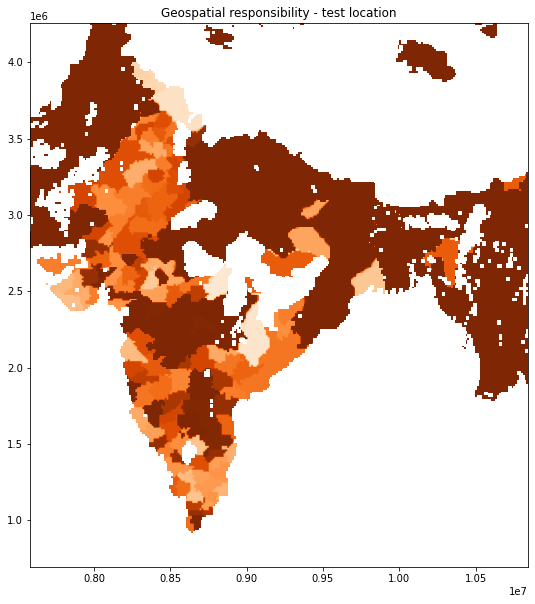

In [42]:
with rio.open(
    "../../datasets/processed/probability_map/purchase_area_distribution_cotton_epsg3857.tif"
) as src:
    image_array = src.read(1)
    fig, ax = plt.subplots(figsize=[15, 10])
    ax.set_ylim((695174.093781, 4.255931e06))
    ax.set_xlim((7.582124e06, 1.084202e07))
    rio.plot.show(
        image_array,
        vmin=2.1023777208029e-06,
        vmax=1.0740570812899e-05,
        cmap="Oranges",
        ax=ax,
        transform=src.transform,
    )
    ax.set_title("Geospatial responsibility - test location")

<a id='finalNotes'></a>
### 4. Final notes

Based on the calculations done above:

- we can generate a worldwide pixel area raster instead of the one specific for each commodity

- we need to extend everyting to all the user data